# Project: Exploring Cook County Housing
## By Letta Tjakrasendjaja

This project explores what can be learned from an extensive housing dataset that is embedded in a dense social context in Cook County, Illinois.

The dataset comes from the Cook County Assessor’s Office (CCAO) in Illinois, a government institution that determines property taxes across most of Chicago’s metropolitan area and its nearby suburbs. In the United States, all property owners are required to pay property taxes, which are then used to fund public services including education, road maintenance, and sanitation. These property tax assessments are based on property values estimated using statistical models that consider multiple factors, such as real estate value and construction cost.

This system, however, is not without flaws. In late 2017, a lawsuit was filed against the office of Cook County Assessor Joseph Berrios for producing “racially discriminatory assessments and taxes." The lawsuit included claims that the assessor’s office undervalued high-priced homes and overvalued low-priced homes, creating a visible divide along racial lines: Wealthy homeowners, who were typically white, paid less in property taxes, whereas working-class, non-white homeowners paid more.

The Chicago Tribune's four-part series, "The Tax Divide", delves into how this was uncovered: After "compiling and analyzing more than 100 million property tax records from the years 2003 through 2015, along with thousands of pages of documents, then vetting the findings with top experts in the field," they discovered that "residential assessments had been so far off the mark for so many years." 

The dataset consists of over 500,000 records from Cook County, Illinois, the county where Chicago is located. The dataset has 61 features in total; the 62nd is sales price, which you will predict with linear regression in the next part of this project. An explanation of each variable can be found in the included codebook.txt file.

The data are split into training and test sets with 204,792 and 68,264 observations, respectively, but we will only be working on the training set for this part of the project.

In this project, I will specify and fit a linear model to a few features of the housing data to predict house prices. Next, I will analyze the error of the model and brainstorm ways to improve the model's performance. Finally, I'll delve deeper into the implications of predictive modeling within the Cook County Assessor's Office (CCAO) case study, especially because statistical modeling is how the CCAO valuates properties. Given the history of racial discrimination in housing policy and property taxation in Cook County, consider the impacts of your modeling results as you work through this project - and think about what fairness might mean to property owners in Cook County.

In [2]:
import numpy as np

import pandas as pd
from pandas.api.types import CategoricalDtype

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model as lm

import warnings
warnings.filterwarnings("ignore")

import zipfile
import os

from ds100_utils import run_linear_regression_test

# Plot settings
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

In [3]:
# First, we load the training data
training_data = pd.read_csv("cook_county_train.csv", index_col='Unnamed: 0')

In [4]:
# Verify that the data shape matches the description: 204,792 observations and 62 features
assert training_data.shape == (204792, 62)
# Sale Price is provided in the training data
assert 'Sale Price' in training_data.columns.values

In [5]:
# Look at all the current columns in our training data.
training_data.columns.values

array(['PIN', 'Property Class', 'Neighborhood Code', 'Land Square Feet',
       'Town Code', 'Apartments', 'Wall Material', 'Roof Material',
       'Basement', 'Basement Finish', 'Central Heating', 'Other Heating',
       'Central Air', 'Fireplaces', 'Attic Type', 'Attic Finish',
       'Design Plan', 'Cathedral Ceiling', 'Construction Quality',
       'Site Desirability', 'Garage 1 Size', 'Garage 1 Material',
       'Garage 1 Attachment', 'Garage 1 Area', 'Garage 2 Size',
       'Garage 2 Material', 'Garage 2 Attachment', 'Garage 2 Area',
       'Porch', 'Other Improvements', 'Building Square Feet',
       'Repair Condition', 'Multi Code', 'Number of Commercial Units',
       'Estimate (Land)', 'Estimate (Building)', 'Deed No.', 'Sale Price',
       'Longitude', 'Latitude', 'Census Tract',
       'Multi Property Indicator', 'Modeling Group', 'Age', 'Use',
       "O'Hare Noise", 'Floodplain', 'Road Proximity', 'Sale Year',
       'Sale Quarter', 'Sale Half-Year', 'Sale Quarter of Year'

In [6]:
training_data['Description'][0]

'This property, sold on 09/14/2015, is a one-story houeshold located at 2950 S LYMAN ST.It has a total of 6 rooms, 3 of which are bedrooms, and 1.0 of which are bathrooms.'

<br/><br/>
<hr style="border: 1px solid #fdb515;" />

# Part 1: Exploratory Data Analysis

This dataset was collected by the Cook County Assessor's Office in order to build a model to predict the monetary value of a home. You can read more about data collection in the CCAO’s Residential Data Integrity Preliminary Report. I will be building a linear regression model that predicts sales prices using training data but it's important to first understand how the structure of the data informs such a model. In this section, we will make a series of exploratory visualizations and feature engineering in preparation for that prediction task.

Note that we will perform EDA on the training data.

### Sale Price
We begin by examining the distribution of our target variable `SalePrice`. At the same time, we also take a look at some descriptive statistics of this variable. We made the following helper method `plot_distribution` that we will use to visualize the distribution of the `SalePrice` using both the histogram and the box plot at the same time.

In [7]:
def plot_distribution(data, label):
    fig, axs = plt.subplots(nrows=2)

    sns.distplot(
        data[label], 
        ax=axs[0]
    )
    sns.boxplot(
        data[label],
        width=0.3, 
        ax=axs[1],
        showfliers=False,
    )

    # Align axes
    spacer = np.max(data[label]) * 0.05
    xmin = np.min(data[label]) - spacer
    xmax = np.max(data[label]) + spacer
    axs[0].set_xlim((xmin, xmax))
    axs[1].set_xlim((xmin, xmax))

    # Remove some axis text
    axs[0].xaxis.set_visible(False)
    axs[0].yaxis.set_visible(False)
    axs[1].yaxis.set_visible(False)

    # Put the two plots together
    plt.subplots_adjust(hspace=0)
    fig.suptitle("Distribution of " + label)

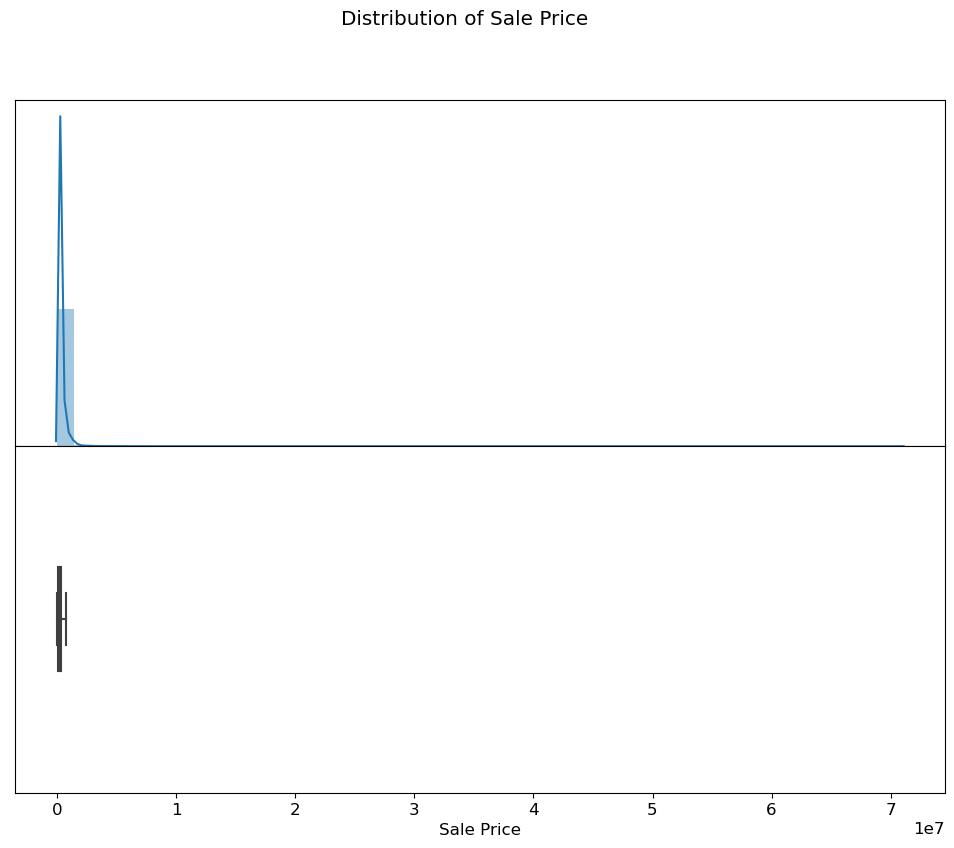

In [8]:
plot_distribution(training_data, label='Sale Price')

One issue with the visualization above is the presence of extreme outliers in the 'Sale Price' column, which makes it difficult to properly observe the distribution and interpret the data. The maximum value is 71000000, while the 3rd quartile is only 312000. This large difference causes the box plot to appear compressed, with the peak very close to 0, making it hard to identify patterns and trends in the data. One way to overcome it is to apply a transformation to the 'Sale Price' column, such as a log transformation, which can help reduce the range of the data and make the distribution less skewed.

In [9]:
training_data['Sale Price'].describe()

count    2.047920e+05
mean     2.451646e+05
std      3.628694e+05
min      1.000000e+00
25%      4.520000e+04
50%      1.750000e+05
75%      3.120000e+05
max      7.100000e+07
Name: Sale Price, dtype: float64

To zoom in on the visualization of most households, we will focus only on a subset of `Sale Price`. In addition, we will be applying log transformation to `Sale Price`. In the cell below, we will reassign `training_data` to a new dataframe that is the same as the original one **except with the following changes**:

- `training_data` should contain only households whose price is at least $500.
- `training_data` should contain a new `Log Sale Price` column that contains the log-transformed sale prices.

In [10]:
training_data_new = training_data[training_data['Sale Price'] >= 500]
training_data_new['Log Sale Price'] = np.log(training_data_new['Sale Price'])

Let's create a new distribution plot on the log-transformed sale price.

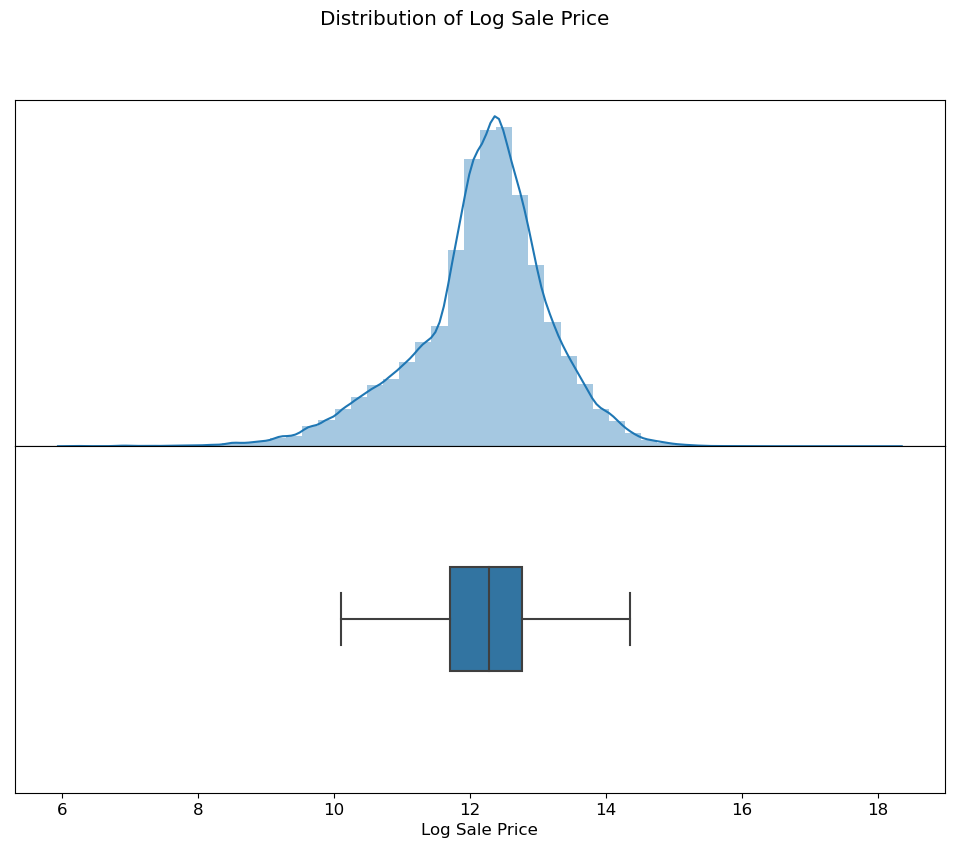

In [11]:
plot_distribution(training_data_new, label='Log Sale Price');

Next, we want to explore if any there is any correlation between Log Sale Price and the total area occupied by the household. The codebook.txt file tells us the column Building Square Feet should do the trick -- it measures "(from the exterior) the total area, in square feet, occupied by the building".

Before creating this jointplot however, we will also apply a log-transformation to the Building Square Feet column.

In the following cell, we will create a new column Log Building Square Feet in our training_data that contains the log-transformed area occupied by each household.

In [12]:
training_data_new['Log Building Square Feet'] = np.log(training_data_new['Building Square Feet'])

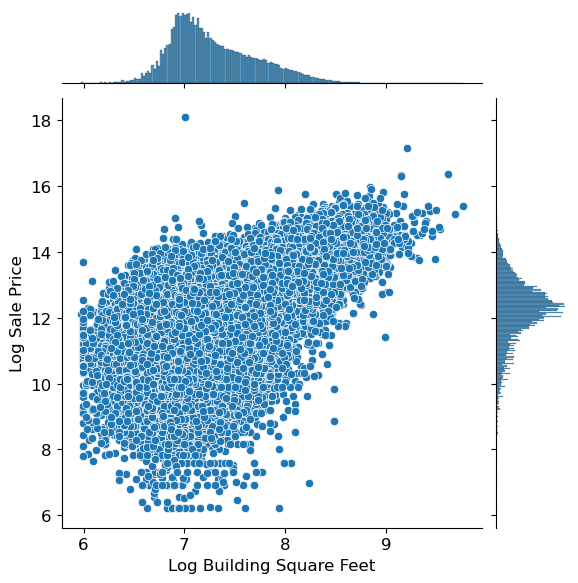

In [13]:
# Create the jointplot
sns.jointplot(data=training_data_new, x='Log Building Square Feet', y='Log Sale Price', kind='scatter')

# Display the plot
plt.show()

Based on the visualization above, `Log Building Square Feet` would make a good candidate as one of the features for our model as it shows a positive correlation between `Log Building Square Feet` and `Log Sale Price`, as indicated by the positive slope of the scatter plot.

For this project, we will work to remove outliers from the data as we run into them. The function `remove_outliers` below removes outliers from the dataset based off a threshold value of a variable.

In [14]:
def remove_outliers(data, variable, lower=-np.inf, upper=np.inf):
    """
    Input:
      data (DataFrame): the table to be filtered
      variable (string): the column with numerical outliers
      lower (numeric): observations with values lower than or equal to this will be removed
      upper (numeric): observations with values higher than this will be removed
    
    Output:
      a DataFrame with outliers removed
      
    Note: This function should not change mutate the contents of data.
    """  
    filtered_data = data[(data[variable] > lower) & (data[variable] <= upper)]

    return filtered_data

<br/><br/>
<hr style="border: 1px solid #fdb515;" />

# Part 2: Feature Engineering

### Bedrooms

Let's start simple by extracting the total number of bedrooms as our first feature for the model. The `Bedrooms` column doesn't actually exist in the original dataframe! Instead, it is part of the `Description` column.



In [15]:
training_data_new['Description'][1]

'This property, sold on 05/23/2018, is a one-story houeshold located at 2844 N LOWELL AVE.It has a total of 6 rooms, 3 of which are bedrooms, and 1.0 of which are bathrooms.'

In [16]:
training_data_new['Description'][2]

'This property, sold on 02/18/2016, is a one-story houeshold located at 11415 S PRAIRIE AVE.It has a total of 7 rooms, 3 of which are bedrooms, and 1.0 of which are bathrooms.'

From the `Description` column, we can **extract** the following variables:
- The date the property was sold on.
- The number of stories the property contains.
- The address of the property.
- The total number of rooms inside the property.
- The total number of bedrooms inside the property.
- The total number of bathrooms inside the property.

Below is a function `add_total_bedrooms(data)` that returns a copy of `data` with an additional column called `Bedrooms` that contains the total number of bedrooms (as integers) for each house. Treat missing values as zeros, if necessary.

In [17]:
def add_total_bedrooms(data):
    """
    Input:
      data (DataFrame): a DataFrame containing at least the Description column.
    """
    with_rooms = data.copy()
    pattern = r'(\d+) of which are bedrooms'
    with_rooms['Bedrooms'] = with_rooms['Description'].str.extract(pattern)
    with_rooms['Bedrooms'] = with_rooms['Bedrooms'].fillna(0).astype(int)    
    return with_rooms

Now we use this function to add the column `Bedrooms` to the dataframe `training_data_new`.

In [18]:
training_data_new = add_total_bedrooms(training_data_new)

<br><br>

---

We will create a visualization that clearly and succintly shows if there exists an association between  `Bedrooms` and `Log Sale Price`.

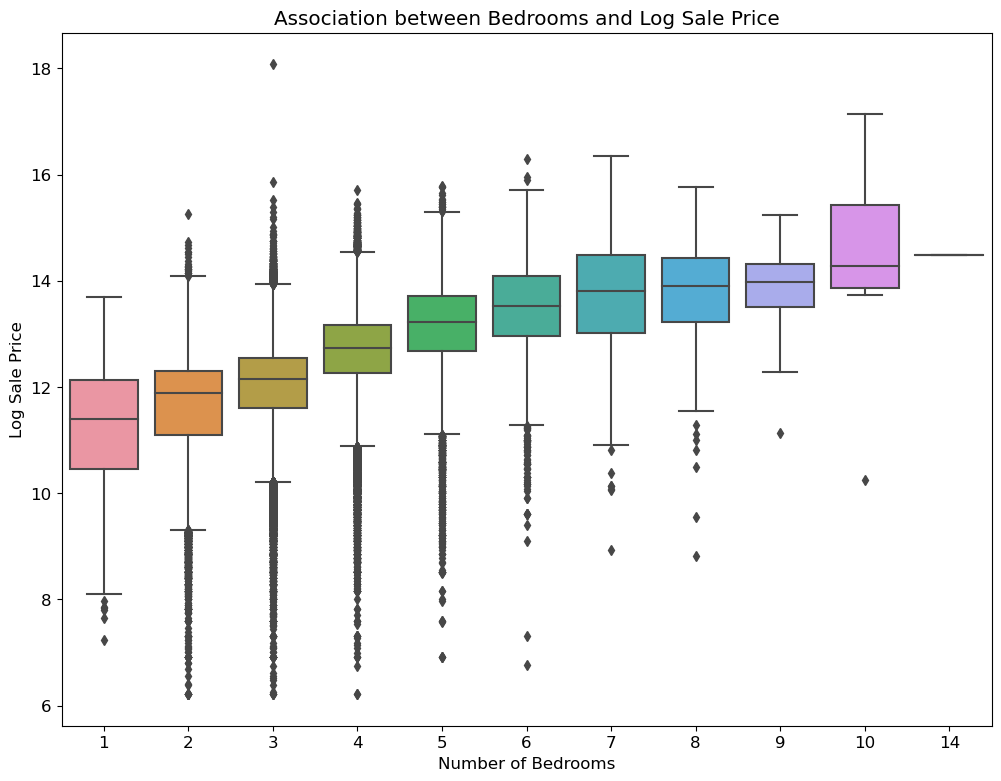

In [19]:
sns.boxplot(x='Bedrooms', y='Log Sale Price', data=training_data_new)
plt.title('Association between Bedrooms and Log Sale Price')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Log Sale Price')
plt.show()

Now, let's take a look at the relationship between neighborhood and sale prices of the houses in our dataset.
Notice that currently we don't have the actual names for the neighborhoods. Instead we will use a similar column `Neighborhood Code` (which is a numerical encoding of the actual neighborhoods by the Assessment office).

Before creating any visualization, let's quickly inspect how many different neighborhoods we are dealing with.

In [20]:
num_neighborhoods = len(training_data_new['Neighborhood Code'].unique())
num_neighborhoods

193

The function `plot_categorical` plots the distributions of `Log Sale Price` for all of the households in each neighborhood. We will use this function to visualize the distribution of sale price within in each neighborhood.

In [21]:
def plot_categorical(neighborhoods):
    fig, axs = plt.subplots(nrows=2)

    sns.boxplot(
        x='Neighborhood Code',
        y='Log Sale Price',
        data=neighborhoods,
        ax=axs[0],
    )

    sns.countplot(
        x='Neighborhood Code',
        data=neighborhoods,
        ax=axs[1],
    )

    # Draw median price
    axs[0].axhline(
        y=training_data_new['Log Sale Price'].median(), 
        color='red',
        linestyle='dotted'
    )

    # Label the bars with counts
    for patch in axs[1].patches:
        x = patch.get_bbox().get_points()[:, 0]
        y = patch.get_bbox().get_points()[1, 1]
        axs[1].annotate(f'{int(y)}', (x.mean(), y), ha='center', va='bottom')

    # Format x-axes
    axs[1].set_xticklabels(axs[1].xaxis.get_majorticklabels(), rotation=90)
    axs[0].xaxis.set_visible(False)

    # Narrow the gap between the plots
    plt.subplots_adjust(hspace=0.01)

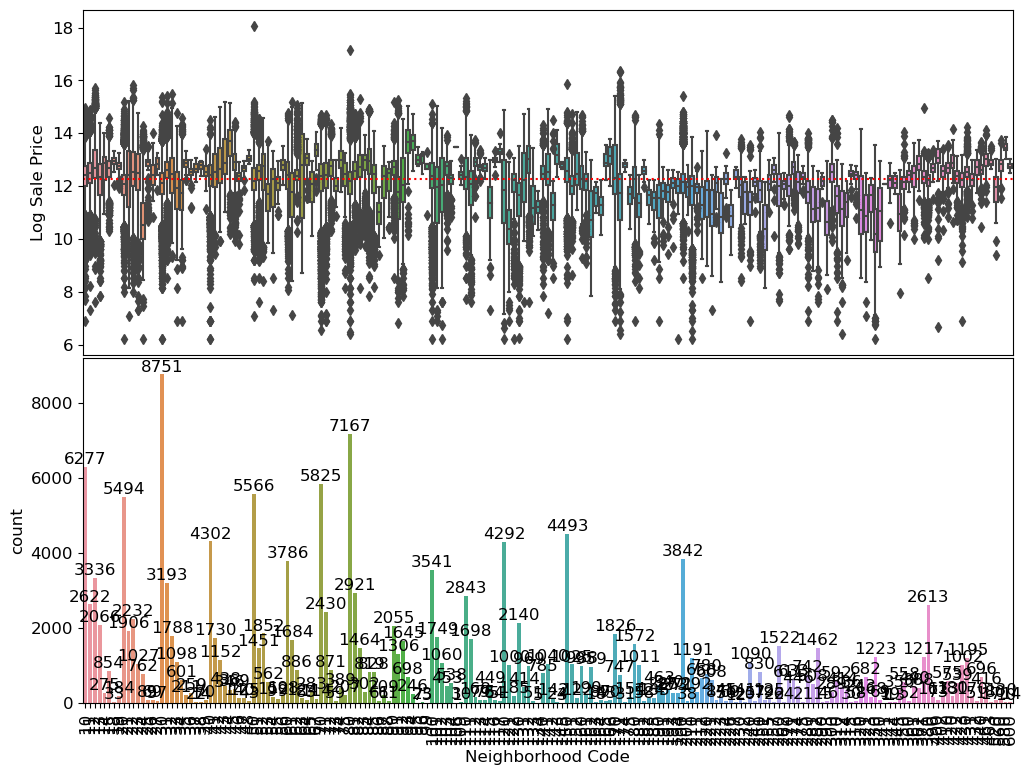

In [22]:
plot_categorical(neighborhoods=training_data_new)

Since there are quiet a few neighborhoods in our dataset, plotting all the neighborhoods will cause the x-axis to be super dense, and our visualization will be overplotted.

We assign the variable `in_top_20_neighborhoods` to a copy of `training_data_new` that contains only top 20 neighborhoods with the most number of houses.

In [23]:
in_top_20_neighborhoods = training_data_new[training_data_new['Neighborhood Code'].isin(training_data_new['Neighborhood Code'].value_counts().sort_values(ascending=False).head(20).index)]

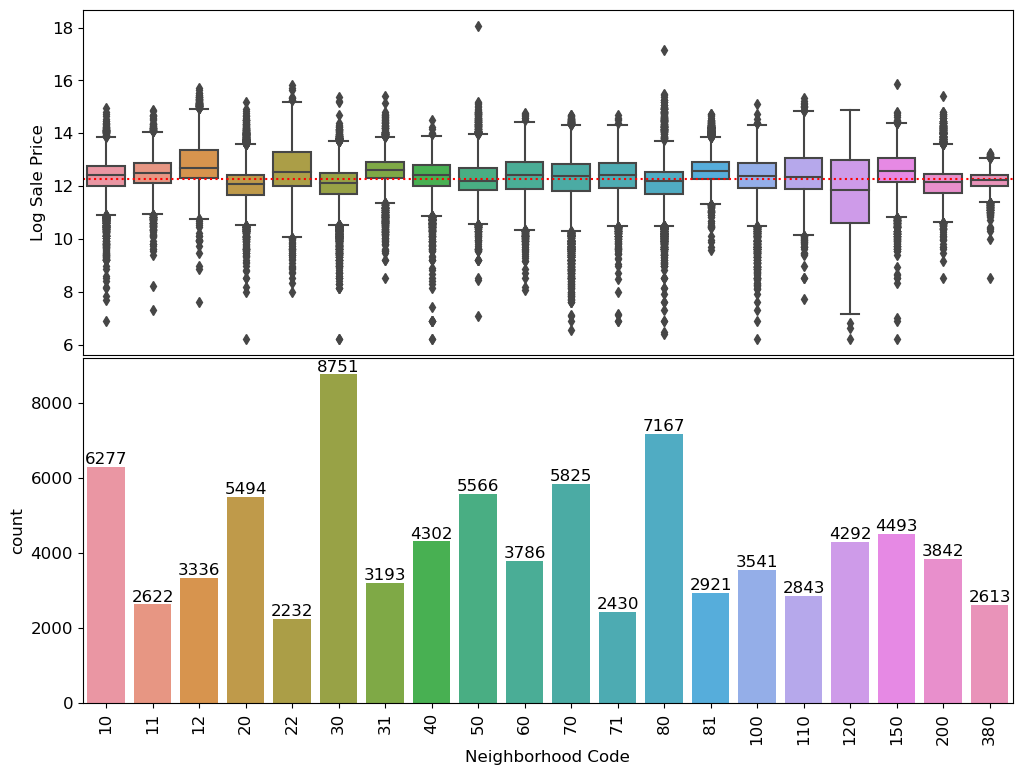

In [24]:
plot_categorical(neighborhoods=in_top_20_neighborhoods)

The box plots for each neighborhood code show different medians and variations in the distribution of Log Sale Prices of each neighborhood, indicating that houses in different neighborhoods have different price ranges. The red dotted line represents the overall median Log Sale Price, which helps to visualize how each neighborhood's median price compares to the overall median. Most of the median for each neighborhood code is pretty close to the overall median, which suggests that the medians of the properties across the top 20 neighborhoods with the most number of houses are similar.

<br><br>

---

One way we can deal with the lack of data from some neighborhoods is to create a new feature that bins neighborhoods together.  Let's categorize our neighborhoods in a crude way: we'll take the top 3 neighborhoods measured by median `Log Sale Price` and identify them as "expensive neighborhoods"; the other neighborhoods are not marked.

Below is a function that returns list of the neighborhood codes of the top `n` most pricy neighborhoods as measured by our choice of aggregating function.

In [25]:
def find_expensive_neighborhoods(data, n=3, metric=np.median):
    """
    Input:
      data (DataFrame): should contain at least a string-valued 'Neighborhood Code'
        and a numeric 'Log Sale Price' column
      n (int): the number of top values desired
      metric (function): function used for aggregating the data in each neighborhood.
        for example, np.median for median prices
    
    Output:
      a list of the the neighborhood codes of the top n highest-priced neighborhoods 
      as measured by the metric function
    """
    neighborhoods = data.groupby('Neighborhood Code').agg(metric).sort_values('Sale Price',ascending=False).head(n).index
    
    # This makes sure the final list contains the generic int type used in Python3, not specific ones used in numpy.
    return [int(code) for code in neighborhoods]

In [26]:
expensive_neighborhoods = find_expensive_neighborhoods(training_data_new, 3, np.median)
expensive_neighborhoods

[44, 94, 93]

We now have a list of neighborhoods we've deemed as higher-priced than others.  Let's use that information to write a function `add_expensive_neighborhood` that adds a column `in_expensive_neighborhood` which takes on the value 1 if the house is part of `expensive_neighborhoods` and the value 0 otherwise. This type of variable is known as an **indicator variable**.

In [27]:
def add_in_expensive_neighborhood(data, neighborhoods):
    """
    Input:
      data (DataFrame): a DataFrame containing a 'Neighborhood Code' column with values
        found in the codebook
      neighborhoods (list of strings): strings should be the names of neighborhoods
        pre-identified as expensive
    Output:
      DataFrame identical to the input with the addition of a binary
      in_expensive_neighborhood column
    """
    data['in_expensive_neighborhood'] = data['Neighborhood Code'].isin(neighborhoods).astype(int)
    return data

In [28]:
expensive_neighborhoods = find_expensive_neighborhoods(training_data_new, 3, np.median)
training_data_new = add_in_expensive_neighborhood(training_data_new, expensive_neighborhoods)

<br><br>

---
We will take a closer look at the `Roof Material` feature of the dataset and examine how we can incorporate categorical features into our linear model.

If we look at `codebook.txt` carefully, we can see that the Assessor's Office uses the following mapping for the numerical values in the `Roof Material` column.
```
Central Heating (Nominal): 

       1	Shingle/Asphalt
       2	Tar&Gravel
       3	Slate
       4	Shake
       5	Tile
       6	Other
```

Below is a function `substitute_roof_material` that replaces each numerical value in `Roof Material` with their corresponding roof material.

In [29]:
def substitute_roof_material(data):
    """
    Input:
      data (DataFrame): a DataFrame containing a 'Roof Material' column.  Its values
                         should be limited to those found in the codebook
    Output:
      DataFrame identical to the input except with a refactored 'Roof Material' column
    """
    data = data.copy()
    data['Roof Material'] = data['Roof Material'].replace({1: 'Shingle/Asphalt', 
                                                           2: 'Tar&Gravel', 
                                                           3: 'Slate', 
                                                           4: 'Shake', 
                                                           5: 'Tile', 
                                                           6: 'Other'})
    return data

In [30]:
training_data_new = substitute_roof_material(training_data_new)
training_data_new.head()

,PIN,Property Class,Neighborhood Code,Land Square Feet,Town Code,Apartments,Wall Material,Roof Material,Basement,Basement Finish,...,Pure Market Filter,Garage Indicator,Neigborhood Code (mapping),Town and Neighborhood,Description,Lot Size,Log Sale Price,Log Building Square Feet,Bedrooms,in_expensive_neighborhood
1,13272240180000,202,120,3780.0,71,0.0,2.0,Shingle/Asphalt,1.0,1.0,...,1,1.0,120,71120,"This property, sold on 05/23/2018, is a one-st...",3780.0,12.560244,6.904751,3,0
2,25221150230000,202,210,4375.0,70,0.0,2.0,Shingle/Asphalt,2.0,3.0,...,1,1.0,210,70210,"This property, sold on 02/18/2016, is a one-st...",4375.0,9.998798,6.810142,3,0
3,10251130030000,203,220,4375.0,17,0.0,3.0,Shingle/Asphalt,1.0,3.0,...,1,1.0,220,17220,"This property, sold on 07/23/2013, is a one-st...",4375.0,12.323856,7.068172,3,0
4,31361040550000,202,120,8400.0,32,0.0,3.0,Shingle/Asphalt,2.0,3.0,...,1,1.0,120,32120,"This property, sold on 06/10/2016, is a one-st...",8400.0,10.025705,6.855409,2,0
6,30314240080000,203,181,10890.0,37,0.0,1.0,Shingle/Asphalt,1.0,3.0,...,1,1.0,181,37181,"This property, sold on 10/26/2017, is a one-st...",10890.0,11.512925,7.458186,4,0


Since `Roof Material` is a categorical variable, we will have to one-hot-encode the data.

The following function `ohe_roof_material` returns a `DataFrame` with the new column one-hot-encoded on the roof material of the household.

In [31]:
from sklearn.preprocessing import OneHotEncoder

def ohe_roof_material(data):
    """
    One-hot-encodes roof material. New columns are of the form "Roof Material_MATERIAL".
    """

    cat = ['Roof Material']
    oh_enc = OneHotEncoder()
    oh_enc.fit(data[cat])
    cat_data = oh_enc.transform(data[cat]).toarray()
    cat_df =  pd.DataFrame(data=cat_data, columns=oh_enc.get_feature_names_out(), index=data.index)
    return data.join(cat_df)

In [32]:
training_data_ohe = ohe_roof_material(training_data_new)
# Return columns with name that starts with "Roof Material_" 
training_data_ohe.filter(regex='^Roof Material_').head(10)

,Roof Material_Other,Roof Material_Shake,Roof Material_Shingle/Asphalt,Roof Material_Slate,Roof Material_Tar&Gravel,Roof Material_Tile
1,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0
6,0.0,0.0,1.0,0.0,0.0,0.0
7,0.0,0.0,1.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,1.0,0.0
9,0.0,0.0,1.0,0.0,0.0,0.0
10,0.0,0.0,1.0,0.0,0.0,0.0
11,0.0,0.0,1.0,0.0,0.0,0.0


<br/><br/>
<hr style="border: 1px solid #fdb515;" />

# Part 3: Preparing Data

The dataset was split into a testing and training set, train on the training set, and compare the prediction on the test set to the observed values. The test set is saved as cook_county_contest_test.csv, and the rest of the data is saved as cook_county_train_val.csv. Note that the prediction `Sale Price` column is not in this test set.

Let's split the dataset into a training set and validation set. We will use the training set to fit our model's parameters, and we will use the validation set to evaluate how well our model will perform on unseen data drawn from the same distribution. If we used all the data to fit our model, we would not have a way to estimate model performance on unseen data such as the test set in `cook_county_contest_test.csv`.

In [3]:
training_val_data = pd.read_csv("cook_county_train_val.csv", index_col='Unnamed: 0')
test_data = pd.read_csv("cook_county_contest_test.csv", index_col='Unnamed: 0')

In the cell below, the function `train_val_split` splits data into two smaller DataFrames named `train` and `validation`. Train contains 80% of the data, and validation contains the remaining 20% of the data. 

In [4]:
np.random.seed(1337)

def train_val_split(data):
    data_len = data.shape[0]
    shuffled_indices = np.random.permutation(data_len)
    train_indices = shuffled_indices[:int(data_len*0.8)]
    validation_indices = shuffled_indices[int(data_len*0.8):]
    train = data.iloc[train_indices]
    validation = data.iloc[validation_indices]
   
    return train, validation
train, validation = train_val_split(training_val_data)